In [2]:
# --- General Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn Imports ---
# For data preparation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# For the model
from sklearn.svm import SVC

# For evaluation
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [3]:


# --- Task 1: Load and Prepare a Dataset for Binary Classification ---

print("--- 1. Loading and Preparing Data ---")

# Load the dataset from the CSV file
df = pd.read_csv('breast-cancer.csv')

# Drop the 'id' column as it's not useful for prediction
df = df.drop('id', axis=1)

# Separate features (X) and the target variable (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# The 'diagnosis' column is categorical ('M' for malignant, 'B' for benign).
# We need to encode it into numerical format.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# 'M' will be encoded as 1, 'B' as 0

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale the features using StandardScaler. This is critical for SVM.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preparation complete.")
print(f"Features have been scaled and the target 'diagnosis' has been encoded (M=1, B=0).")
print(f"Training set has {X_train_scaled.shape[0]} samples.")
print(f"Testing set has {X_test_scaled.shape[0]} samples.\n")

--- 1. Loading and Preparing Data ---
Data preparation complete.
Features have been scaled and the target 'diagnosis' has been encoded (M=1, B=0).
Training set has 455 samples.
Testing set has 114 samples.



In [4]:
# --- Task 2: Train an SVM with Linear and RBF Kernels ---

print("--- 2. Training SVM with Linear and RBF Kernels ---")

# Train a Linear SVM
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_scaled, y_train)
y_pred_linear = svm_linear.predict(X_test_scaled)
accuracy_linear = accuracy_score(y_test, y_pred_linear)
print(f"Accuracy of Linear SVM: {accuracy_linear:.4f}")

# Train an RBF Kernel SVM (with default parameters for now)
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svm_rbf.predict(X_test_scaled)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"Accuracy of RBF SVM (default params): {accuracy_rbf:.4f}\n")

--- 2. Training SVM with Linear and RBF Kernels ---
Accuracy of Linear SVM: 0.9649
Accuracy of RBF SVM (default params): 0.9737



--- 3. Visualizing Decision Boundaries ---


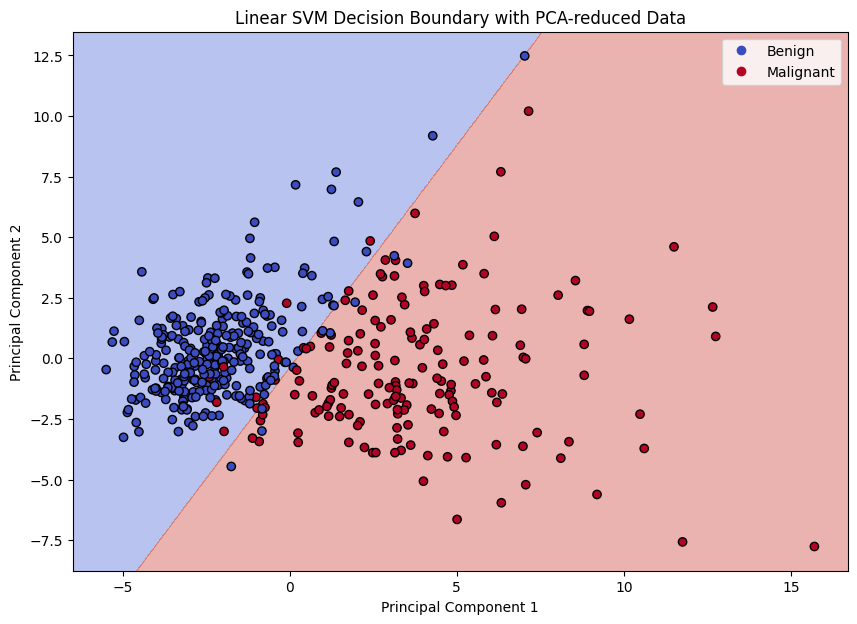

Displayed the decision boundary for the Linear SVM.



In [5]:
# --- Task 3: Visualize Decision Boundary using 2D Data ---

print("--- 3. Visualizing Decision Boundaries ---")

# To visualize, we reduce the data to 2 dimensions using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Create and train a new linear SVM on the 2D PCA data
svm_linear_pca = SVC(kernel='linear', random_state=42)
svm_linear_pca.fit(X_train_pca, y_train)

# Create a mesh grid for plotting the decision boundary
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Get predictions for the mesh grid
Z = svm_linear_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Linear SVM Decision Boundary with PCA-reduced Data')
plt.legend(handles=scatter.legend_elements()[0], labels=['Benign', 'Malignant'])
plt.show()
print("Displayed the decision boundary for the Linear SVM.\n")

--- 4 & 5. Tuning Hyperparameters with GridSearchCV (which uses Cross-Validation) ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma

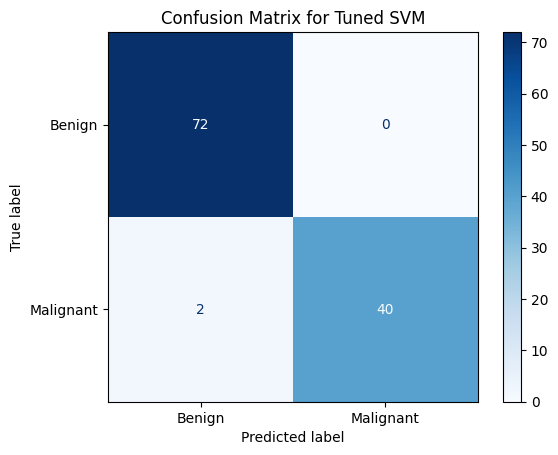

In [7]:
# --- Task 4 & 5: Tune Hyperparameters (C, gamma) with Cross-Validation ---

print("--- 4 & 5. Tuning Hyperparameters with GridSearchCV (which uses Cross-Validation) ---")

# Define the parameter grid to search
# C is the regularization parameter
# gamma defines how far the influence of a single training example reaches
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf'] # We focus on the RBF kernel as it's more flexible
}

# Instantiate GridSearchCV
# cv=5 means 5-fold cross-validation
grid_search = GridSearchCV(SVC(random_state=42), param_grid, refit=True, verbose=2, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters found by the grid search
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}\n")

# --- Final Model Evaluation ---
print("--- Evaluating the Tuned Model on the Test Set ---")
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, y_pred_best)

print(f"Final Accuracy on Test Set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Benign', 'Malignant']))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(best_svm, X_test_scaled, y_test, cmap='Blues', display_labels=['Benign', 'Malignant'])
plt.title('Confusion Matrix for Tuned SVM')
plt.show()